# #PharmaTwitter


Having found the Harvard Business Review's ranking of the most skilled companies on twitter ["50 Companies That Get Twitter – and 50 That Don’t"](https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters), I decided to carry out a small analysis myself. 

The HBR's analysis was conducted on 350,00 tweets of 300 companies listed on NASDAQ, NYSE or FTSE and presents an "empathy" scoring, where the most empathetic companies are on top. Even though the author explains that the methodology assumes empathy consists of: "reassurance, authenticity, and emotional connection" it's a difficult task to actually measure it in real life. I am going to try nevertheless.

Code can be found on my GitHub account: [mbalcerzak](https://github.com/mbalcerzak/twitter_pharma)

## Problem statement and hypothesis explanation

The new generation get their news from social media. Twitter is a way to communicate with the public, educate patients, solve problems and inform. That's why it's so important to engage with the followers in an authentic and empathetic way. 

According to the article ["It’s Time to Tweet—How Pharma Should Be Using Twitter"](https://www.pm360online.com/its-time-to-tweet-how-pharma-should-be-using-twitter/) there are numerous benefits to engaging with patients and investors on social media:
 - most pharmaceutical companies already actively use Twitter
 - accessible and timely information for patients, investors and regulators
 - interacting with opinion leaders and "pharmaceutical influencers"
 - increased company reputation
 - better customer service
 - advertising opportunity (also for future hiring)

In the 2015 HBR's ranking ["50 Companies That Get Twitter – and 50 That Don’t"](https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters) AstraZeneca holds the last place as the least "empathetic" company Twitter account. The following year HBR released a second ranking with Novartis and Johnson & Johnson in top 11 [(link)](https://twitter.com/harvardbiz/status/805712993384353792) at the same time stating that companies with higher empathy generate more revenue. As we know correlation doesn't equal causation... but it's always worth checking if there anything that "more empathetic" companies do differently than others.

I am going to conduct an analysis of pharmaceutical comapnies' tweets focusing on posting patterns (time of day, frequency) and words used (do those words communicate empathy?). Then I hope to find out if there is anything "less empathetic" companies might improve in the future when it comes to their social media activity.

## Web Scraping - getting the data

Tweets of the chosen companies were collected using [**tweepy**](https://www.tweepy.org/) package for Python 3.7. All accounts are officially verified. 
- [AstraZeneca](https://twitter.com/AstraZeneca) 
- [Johnson & Johnson](https://twitter.com/JNJCares) (JNJCares)  
- [Roche](https://twitter.com/Roche)
- [Pfizer](https://twitter.com/Pfizer) 
- [Novartis](https://twitter.com/Novartis)
- [BayerPharma](https://twitter.com/BayerPharma) 
- [Merck](https://twitter.com/Merck) 
- [GSK](https://twitter.com/GSK) 
- [Sanofi](https://twitter.com/Sanofi)
- [Abbvie](https://twitter.com/abbvie)
- [Abbott](https://twitter.com/AbbottGlobal) (AbbottGlobal)  
- [Eli Lilly and Company](https://twitter.com/LillyPad) (LillyPad)  
- [Amgen](https://twitter.com/Amgen) 
- [Bristol-Myers Squibb](https://twitter.com/bmsnews)  (bmsnews)  
- [GileadSciences](https://twitter.com/GileadSciences) 

Code I used to scrape the data lives on my GitHub page: [mbalcerzak/../webscraping/](https://github.com/mbalcerzak/twitter_pharma/tree/master/web_scraping)

In [226]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [227]:
# packages used

import pandas as pd
import numpy as np
from scipy import stats
import collections
import re
import os
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display

from nltk.probability import ConditionalFreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# setting up language for stopwords
stop_words = set(stopwords.words('english'))

In [228]:
path = 'C:/Users/malgo_000/Desktop/Web_scraping/twitter_scraping/tweet_texts_pharma/'
#path = os.path.join(os.getcwd(), 'tweet_texts_pharma/')

def prepare_dataset(company):   
    df = pd.read_csv(path + '%s_tweets.txt' % company, sep = '|')
    
    df['company'] = company[0].upper() + company[1:]
    df['id'] = df['id'].apply(str)
    
    df['hashtags'] = df['text'].apply(lambda s: re.findall(r'#(\w+)', s))
    df['num_hash'] = df['hashtags'].apply(len)
    
    df['tagged'] = df['text'].apply(lambda s: re.findall(r'@(\w+)', s))
    
    def clean_tweet(tweet):
        check = '(@[A-Za-z]+)|([^A-Za-z \t\&])|(\w+:\/\/\S+)'
        return ' '.join([x.lower() for x in re.sub(check, ' ', tweet).split()])
        
    df['clean_tweet'] = [clean_tweet(tweet.replace('&amp;','&')).replace(' & ','&') for tweet in df['text']]    
    df['len'] = df['clean_tweet'].apply(len)
    df['text_as_list'] = df['clean_tweet'].str.split(' ')

    def lem_tweet(list_of_words):
        lemm = WordNetLemmatizer()
        return ' '.join([lemm.lemmatize(x.lower()) for x in list_of_words.split(' ') if x not in stop_words])

    df['text_list_lemm'] = [lem_tweet(tweet) for tweet in df['clean_tweet']]
    df['text_list_lemm'] = df['text_list_lemm'].str.split(' ')
    
    df['datetime'] = pd.to_datetime(df['created_at'])
    df['date'] = df['datetime'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df['hour'] = df['datetime'].apply(lambda x: x.hour) 
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['day'] = df['datetime'].apply(lambda x: x.day)
    df['year'] = df['datetime'].apply(lambda x: x.year)
    df = df.drop(columns = ['created_at'])
    
    df['z'] = np.abs(stats.zscore(df['fav']))
    
    return df

df = prepare_dataset('AstraZeneca')

## Exploratory Data Analysis

Let's explain what the variables mean:

>**id** - unique identifier for a tweet  
**text** - UTF-8 text of the status update  
**retweet** - was it an original post or a retweet  
**source** - what device was used to post  
**fav** -  how many likes it received  
**RT** - how many times was that post retweeted  
**hashtags** - what hashtags were used   
**num_hash** - number of hashtags used  
**company** - name of the posting account  
**tagged** - which accounts were mentioned  
**clean_tweet** - text without special characters  
**len** -  length of the clean tweet  
**text_as_list** - clean tweet in a form of list  
**text_list_lemm** - list of lemmtized words that are not stopwords  
**datetime** - date and time of posting a tweet, later split into: **date**, **hour**, **month**, **day**, **year**   
**z** - Z-score value

In [229]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

display(df.head(3))

,id,text,retweet,source,fav,RT,hashtags,company,num_hash,tagged,clean_tweet,len,text_as_list,text_list_lemm,datetime,date,hour,month,day,year,z
0,1140218482409144320,"While progress has been made, there is still unmet medical need for people with chronic lymphocytic #leukaemia (CLL). For many, the disease may return even after successful treatment. We’re committed to advancing the science to transform cancer care for these patients. #EHA24 https://t.co/csEGUUf7Ym",False,Percolate,8,4,"[leukaemia, EHA24]",AstraZeneca,2,[],while progress has been made there is still unmet medical need for people with chronic lymphocytic leukaemia cll for many the disease may return even after successful treatment we re committed to advancing the science to transform cancer care for these patients eha,265,"[while, progress, has, been, made, there, is, still, unmet, medical, need, for, people, with, chronic, lymphocytic, leukaemia, cll, for, many, the, disease, may, return, even, after, successful, treatment, we, re, committed, to, advancing, the, science, to, transform, cancer, care, for, these, patients, eha]","[progress, made, still, unmet, medical, need, people, chronic, lymphocytic, leukaemia, cll, many, disease, may, return, even, successful, treatment, committed, advancing, science, transform, cancer, care, patient, eha]",2019-06-16 11:24:05,2019-06-16,11,6,16,2019,0.029039
1,1140177930796093441,It's #pridemonth. Yesterday our colleagues and their familes walked in the #Gothenburg West Pride. We are proud of our Swedish heritage and Gothenburg is home to many of our people. Read more about our #LGBTQIA+ Employee Resource Groups https://t.co/MpcRomxoVX - #thisisAZ https://t.co/A8WAkkdWvu,False,Twitter for iPhone,11,2,"[pridemonth, Gothenburg, LGBTQIA, thisisAZ]",AstraZeneca,4,[],it s pridemonth yesterday our colleagues and their familes walked in the gothenburg west pride we are proud of our swedish heritage and gothenburg is home to many of our people read more about our lgbtqia employee resource groups thisisaz,238,"[it, s, pridemonth, yesterday, our, colleagues, and, their, familes, walked, in, the, gothenburg, west, pride, we, are, proud, of, our, swedish, heritage, and, gothenburg, is, home, to, many, of, our, people, read, more, about, our, lgbtqia, employee, resource, groups, thisisaz]","[pridemonth, yesterday, colleague, familes, walked, gothenburg, west, pride, proud, swedish, heritage, gothenburg, home, many, people, read, lgbtqia, employee, resource, group, thisisaz]",2019-06-16 08:42:56,2019-06-16,8,6,16,2019,0.025737
2,1139919536193335297,"Today marks 100 days until the start of #ClimateWeekNYC by @climategroup. As a member of #RE100, we believe 2019 is a critical year for accelerating global climate action. https://t.co/ll4NaORABY https://t.co/y2xpcbg3eS",False,Percolate,5,2,"[ClimateWeekNYC, RE100]",AstraZeneca,2,[climategroup],today marks days until the start of climateweeknyc by as a member of re we believe is a critical year for accelerating global climate action,140,"[today, marks, days, until, the, start, of, climateweeknyc, by, as, a, member, of, re, we, believe, is, a, critical, year, for, accelerating, global, climate, action]","[today, mark, day, start, climateweeknyc, member, believe, critical, year, accelerating, global, climate, action]",2019-06-15 15:36:10,2019-06-15,15,6,15,2019,0.032341


### Removing outliers

Outliers can distort the analysis results, that's why I am going to exclude them from the dataset.

There are two tweets that can be classified as outliers. They both received significanly more likes and were retweeted more frequently than the rest of AstraZeneca's tweets and would artificially inflate the company's statistics. 

Both will be removed from the dataset using Z-score metric:

```python
df['z'] = np.abs(stats.zscore(df['fav']))
```

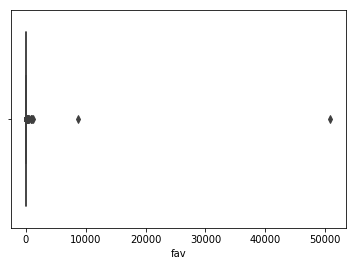

In [230]:
sns.boxplot(x = df['fav'])

In [231]:
display(df[df['z'] >= 3])

,id,text,retweet,source,fav,RT,hashtags,company,num_hash,tagged,clean_tweet,len,text_as_list,text_list_lemm,datetime,date,hour,month,day,year,z
273,1105192019507462144,AstraZeneca confirms we no longer advertise on the Tucker Carlson show and we will not be advertising on this program in the future.,True,Twitter Web Client,8656,2111,[],AstraZeneca,0,[],astrazeneca confirms we no longer advertise on the tucker carlson show and we will not be advertising on this program in the future,131,"[astrazeneca, confirms, we, no, longer, advertise, on, the, tucker, carlson, show, and, we, will, not, be, advertising, on, this, program, in, the, future]","[astrazeneca, confirms, longer, advertise, tucker, carlson, show, advertising, program, future]",2019-03-11 19:41:25,2019-03-11,19,3,11,2019,9.490501
1398,973920289850576896,"""Look up at the stars and not down at your feet"" - Professor Stephen Hawking\r\n1942-2018 https://t.co/h8uWznhEpb https://t.co/RVeQx2BTxP",True,Twitter Web Client,50854,31990,[],AstraZeneca,0,[],look up at the stars and not down at your feet professor stephen hawking,72,"[look, up, at, the, stars, and, not, down, at, your, feet, professor, stephen, hawking]","[look, star, foot, professor, stephen, hawking]",2018-03-14 13:54:26,2018-03-14,13,3,14,2018,55.941188


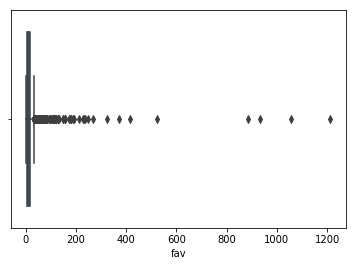

In [232]:
df = df[df['z'] < 3]
sns.boxplot(x = df['fav'])

### AastraZeneca's statistics

Dataset with AZ's posts has 3226 unique tweets from 10th June 2016 to 16th June 2019. 

In [233]:
print('Average length of an AstraZeneca tweet: {}'.format(round(np.mean(df['len']))))
print('Number of likes for the most liked tweet: {}'.format(np.max(df['fav'])))
print('An average tweet received {} likes'.format(round(np.mean(df['fav']))))
print('AZ tweets got on average {} likes and retweets {}'.format(round(np.mean(df['fav'][df['retweet'] == False])),
                                                                 round(np.mean(df['fav'][df['retweet'] == True]))))

Average length of an AstraZeneca tweet: 140
Number of likes for the most liked tweet: 1213
An average tweet received 16 likes
AZ tweets got on average 12 likes and retweets 31


In [234]:
print('A tweet that received the most likes:')
display(df[['clean_tweet','hashtags','fav','RT']][df['fav'] == max(df['fav'])])

print('Most liked non-retweeted (original) tweet:')
df_org = df[df['retweet'] == False]
display(df_org[['clean_tweet','hashtags','fav','RT']][df_org['fav'] == max(df_org['fav'])])

A tweet that received the most likes:


,clean_tweet,hashtags,fav,RT
956,happy lgbtstemday one and all let s work together for more inclusivity and more support for lgbtq people in stem,[LGBTSTEMDay],1213,790


Most liked non-retweeted (original) tweet:


,clean_tweet,hashtags,fav,RT
845,we are named a global sustainability leader by the dow jones sustainability index we received industry top scores in the areas environmental reporting labour practice indicators and health outcome contribution sustainability djsi esg,"[sustainability, DJSI, ESG]",325,16


### Getting data about companies' accounts

Let's see what bios companies put and how many followers they acquired so far

In [235]:
path_accounts = 'C:/Users/malgo_000/Desktop/Web_scraping/twitter_scraping/followers_info/'
#path = os.path.join(os.getcwd(), 'followers_info/')

def prepare_user_info():
    df = pd.read_csv(path_accounts + 'pharma_accounts.txt', sep = '|')
    df['datetime'] = pd.to_datetime(df['created_at'])
    df['date_created'] = df['datetime'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df = df.drop(columns = ['created_at', 'datetime'])
    df['screen_name'] = df['screen_name'].apply(lambda x: x[0].upper() + x[1:]) 
    
    return df.set_index('screen_name')

accounts_info = prepare_user_info()

Most bios focus on presenting the company's mission. They contain words such as 'life-changing' or 'purpose' and explain how they want to improve patients' lives using innovative technology

>**followers** - how many followers that account has  
**favourites_count** - how many likes were given by that account     
**statuses_count** - how many tweets that account posted

In [236]:
accounts_info.sort_values(by = 'followers', ascending = False)

,user_id,bio,followers,locations,statuses_count,favourites_count,date_created
screen_name,,,,,,,
Novartis,17226612,Our purpose is to reimagine medicine to improve and extend people’s lives. See our community guidelines: https://t.co/bfijfsfZgl,251365,"Basel, Switzerland",11972,417,2008-11-07
Pfizer,56488059,Breakthroughs that change patients' lives. Visit https://t.co/YjZgM1r3ic to learn more. https://t.co/K5kUC0xMQ2,243699,"New York, NY",8569,494,2009-07-13
Roche,20815041,Our vision is to transform the lives of people everywhere - ensuring the right treatment for the right patient at the right time.,193725,"Basel, Switzerland",11514,1538,2009-02-13
GSK,5383942,Latest news and views from science-led global healthcare company GSK. Run by the global digital comms team. Code of Conduct: https://t.co/kKvxeMiGzq,181042,"London, UK",10974,1335,2007-04-21
Merck,35961145,We have always been and always will be inventing for the single greatest purpose: Life. Intended for U.S. residents only. FLS: https://t.co/unmH53cudx,170280,"Kenilworth, NJ",7629,1660,2009-04-28
AstraZeneca,62465691,We're driven by innovative science to deliver life-changing medicines to millions of patients worldwide.,158105,Global,6406,2997,2009-08-03
BayerPharma,44314871,The global pharmaceutical division of @Bayer. Data Privacy / Imprint: https://t.co/iMFreBzROL,142569,"Berlin, Germany",7584,4094,2009-06-03
Bmsnews,34010976,Global Specialty Care BioPharma,132409,"New York, New York",6573,811,2009-04-21
LillyPad,172496840,Lilly unites caring with discovery to create medicines that make life better for people around the world. https://t.co/kmcZ4vksWQ,113423,"Indianapolis, IN",20640,1724,2010-07-29


### Creating a combined dataset of all companies' tweets

In [237]:
def combine_tweets(company_names):
    df_all = pd.DataFrame()
    for company in company_names:
        df_all = df_all.append(prepare_dataset(company))        
    
    df_all = df_all[df_all['z'] < 3] 
    df_all = df_all.append(df)
    
    return df_all

company_list = ['JNJCares', 'Roche', 'Pfizer','Novartis', 'BayerPharma',
                'Merck','GSK','Sanofi', 'abbvie', 'AbbottGlobal',
                'LillyPad', 'Amgen', 'bmsnews', 'GileadSciences']

df_all = combine_tweets(company_list)
df_all.sample(3)

,id,text,retweet,source,fav,RT,hashtags,company,num_hash,tagged,clean_tweet,len,text_as_list,text_list_lemm,datetime,date,hour,month,day,year,z
3154,770281366093197312,"@GimmieThatLoot Thank you for your response. We understand time is precious. When you have time just send us a DM, so we may learn more.",False,Spredfast,0,0,[],JNJCares,0,[GimmieThatLoot],thank you for your response we understand time is precious when you have time just send us a dm so we may learn more,116,"[thank, you, for, your, response, we, understand, time, is, precious, when, you, have, time, just, send, us, a, dm, so, we, may, learn, more]","[thank, response, understand, time, precious, time, send, u, dm, may, learn]",2016-08-29 15:26:03,2016-08-29,15,8,29,2016,0.198865
540,1003276817317421057,@justaguywa2 You may be eligible for @LillyDiabetes’ insulin affordability programs. For more information visit https://t.co/ltKQpRwiiz.,False,Spredfast app,0,0,[],LillyPad,0,"[justaguywa2, LillyDiabetes]",you may be eligible for insulin affordability programs for more information visit,81,"[you, may, be, eligible, for, insulin, affordability, programs, for, more, information, visit]","[may, eligible, insulin, affordability, program, information, visit]",2018-06-03 14:06:47,2018-06-03,14,6,3,2018,0.424652
2355,769893815348060160,Here's the latest on treating multidrug-resistant #tuberculosis in India: https://t.co/Rp7sxmKvvs #StopTB,False,Spredfast app,6,13,"[tuberculosis, StopTB]",LillyPad,2,[],here s the latest on treating multidrug resistant tuberculosis in india stoptb,78,"[here, s, the, latest, on, treating, multidrug, resistant, tuberculosis, in, india, stoptb]","[latest, treating, multidrug, resistant, tuberculosis, india, stoptb]",2016-08-28 13:46:04,2016-08-28,13,8,28,2016,0.136801


### Overall statistics

All tweets were collected up to a similar point in time (June 2019). On average each company has 3198 tweets. Some of them date back to 2012 but I'm mostly interested in tweets posted after 2015. Tweets from the following years will help check the hypothesis presented in HBR's ranking outcomes. 

The most active account seems to be **Eli Lilly and Company** posting on average 6 tweets a day. Least active would be Gilead Sciences with only around 1 tweet per day. 

>**date max** - latest tweet of that account in the dataset    
**date min** - earliest tweet of that account in the dataset  
**statuses collected** - how many tweets belong to that particular account  
**date_created** - date of establishing the account  
**days** - difference between latest and earliest post in days   
**days_begin** - the account is that many days old counting up to "date max" value from date_created  
**Tweets/day** - daily frequency of tweeting in the analysed period  
**Tweets/day_begin** - daily frequency of tweeting overall  

In [238]:
counts = df_all[['id','company']].groupby('company').count()
counts.rename(columns = {'id':'statuses collected'}, inplace = True)

statistics = [max, min]
grouped = df_all[df_all['retweet'] == False].groupby('company').agg({"date" : statistics}) 
grouped.columns = [" ".join(x) for x in grouped.columns.ravel()]

grouped_info = pd.concat([grouped, counts, accounts_info[['date_created','statuses_count']]], axis = 1, sort = True)

grouped_info['date max'] = pd.to_datetime(grouped_info['date max'])
grouped_info['date min'] = pd.to_datetime(grouped_info['date min'])
grouped_info['date_created'] = pd.to_datetime(grouped_info['date_created'])

grouped_info['days'] = (grouped_info['date max'] - grouped_info['date min']).apply(lambda x: x.days)
grouped_info['Tweets/day'] = (grouped_info['statuses collected'] / grouped_info['days']).apply(int)

grouped_info['days_begin'] = (grouped_info['date max'] - grouped_info['date_created']).apply(lambda x: x.days)
grouped_info['Tweets/day_begin'] = (grouped_info['statuses_count'] / grouped_info['days_begin']).apply(int)

display(grouped_info)

print("On average, analysed accounts tweet {} times per day".format(round(np.mean(grouped_info['Tweets/day']))))

,date max,date min,statuses collected,date_created,statuses_count,days,Tweets/day,days_begin,Tweets/day_begin
AbbottGlobal,2019-06-15,2016-03-01,3210,2013-10-04,4997,1201,2,2080,2
Abbvie,2019-06-16,2016-05-10,3229,2012-03-21,5608,1132,2,2643,2
Amgen,2019-06-16,2017-05-17,3191,2009-04-02,8518,760,4,3727,2
AstraZeneca,2019-06-16,2016-06-10,3226,2009-08-03,6406,1101,2,3604,1
BayerPharma,2019-06-15,2016-03-15,3192,2009-06-03,7584,1187,2,3664,2
Bmsnews,2019-06-16,2016-06-07,3227,2009-04-21,6573,1104,2,3708,1
GSK,2019-06-16,2017-02-15,3237,2007-04-21,10974,851,3,4439,2
GileadSciences,2019-06-15,2012-03-23,2980,2011-06-02,3021,2640,1,2935,1
JNJCares,2019-06-11,2016-08-03,3220,2010-04-30,14317,1042,3,3329,4
LillyPad,2019-06-13,2016-04-27,3180,2010-07-29,20640,1142,2,3241,6


On average, analysed accounts tweet 2 times per day


Both AZ and Novarits tweet 2 times per day, Johnson & Johnson tweets on average 3 times per day. That doesn't seem like a big difference

In [239]:
statistics = [max, np.median]
grouped = df_all[df_all['retweet'] == False].groupby('company').agg({"fav" : statistics,
                                                                     "RT" : statistics,
                                                                     "len": statistics,
                                                                     "num_hash": statistics}) 
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

grouped.sort_values(by = 'fav_median', ascending = False)

,fav_max,fav_median,RT_max,RT_median,len_max,len_median,num_hash_max,num_hash_median
company,,,,,,,,
Merck,2590,15,2309,7,272,93,7,1
Pfizer,1600,12,798,5,274,109,5,1
GSK,277,11,136,5,276,125,7,1
Novartis,237,11,163,5,272,96,7,1
Roche,66,10,44,4,267,109,6,2
AstraZeneca,325,9,154,4,275,127,25,2
Abbvie,115,8,49,3,268,98,6,1
Bmsnews,1711,8,630,4,261,95,7,2
BayerPharma,270,6,154,4,268,100,8,2


The most liked tweet received 2590 likes whereas overall median equals 7. One of the tweets was retweeted 2309 times while all companies' median is 3. Usually companies don't use all the available characters. The record number of hashtags is 25 and is held by AstraZeneca. Most liked tweet was posted by Merck

In [240]:
statistics = [max, np.median]
grouped = df_all[df_all['retweet'] == False].agg({"fav" : statistics,
                                                  "RT" : statistics,
                                                  "len": statistics,
                                                  "num_hash": statistics}) 
grouped.columns = ["".join(x) for x in grouped.columns.ravel()]
grouped.astype(int)

,fav,RT,len,num_hash
max,2590,2309,285,25
median,7,3,106,1


In [241]:
class Tweet(object):
    def __init__(self, embed_str = None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

##### Most liked tweet from the whole dataset:

In [242]:
record_likes = ("""
<blockquote class="twitter-tweet" data-lang="pl"><p lang="en" dir="ltr">Embracing his responsibility. Following his conscience. Strengthening his country. For these attributes and more, <a href="https://twitter.com/TIME?ref_src=twsrc%5Etfw">@TIME</a> names our CEO Ken Frazier to their 2018 <a href="https://twitter.com/hashtag/TIME100?src=hash&amp;ref_src=twsrc%5Etfw">#TIME100</a> list: <a href="https://t.co/zBFMisSM0Y">https://t.co/zBFMisSM0Y</a> <a href="https://t.co/gyNlKzbSBH">pic.twitter.com/gyNlKzbSBH</a></p>&mdash; Merck (@Merck) <a href="https://twitter.com/Merck/status/986995122385686528?ref_src=twsrc%5Etfw">19 kwietnia 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(record_likes)

##### Tweet with the highest number of hashtags in the whole dataset:

In [243]:
record_hash_num = ("""
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">We&#39;re so excited to have <a href="https://twitter.com/hashtag/280characters?src=hash&amp;ref_src=twsrc%5Etfw">#280characters</a> to talk about more <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a> <a href="https://twitter.com/hashtag/science?src=hash&amp;ref_src=twsrc%5Etfw">#science</a></p>&mdash; AstraZeneca (@AstraZeneca) <a href="https://twitter.com/AstraZeneca/status/928067467649409027?ref_src=twsrc%5Etfw">November 8, 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(record_hash_num)

### Tweeting frequency and timing

The plot below shows tweeting frequency for AstraZeneca. Blue line signifies all companies' average number of tweets per day (2). Usually,  AZ is tweeting more frequently per day than the "industry average"

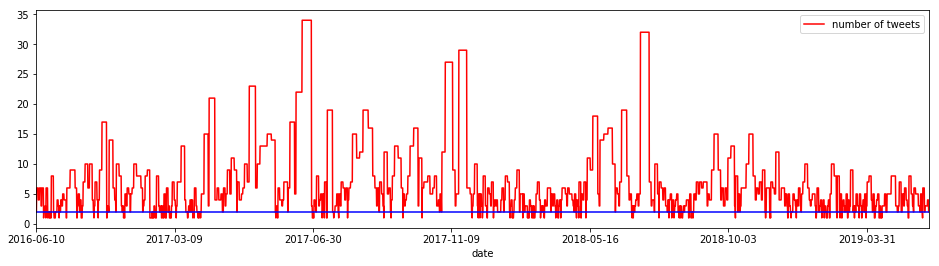

AstraZeneca was tweeting more frequently than all companies's average (blue line) 59.7% of the time


In [244]:
time_fav = pd.Series(data = df['date'].value_counts(), index = df['date'][::-1])
time_plt = time_fav.plot(figsize=(16, 4), label = 'number of tweets', color = 'r', legend = True)  

industry_avg = round(np.mean(grouped_info['Tweets/day']))

plt.axhline(industry_avg, color = 'b', label = 'data')
plt.show()

prc = round(sum([1 for x in df['date'].value_counts() if x > industry_avg])/len(df['date'].value_counts())*100,1)
print('AstraZeneca was tweeting more frequently than all companies\'s average (blue line) {}% of the time'.format(prc))

#### What happened during the peaks? 

AZ tweets on average twice a day those pikes seem especially interesting. I will print out the hashtags that are mentioned on those peak days.

In [245]:
def pike_days_hashtags(company, n):   
    data = df_all['date'][df_all['company'] == company].value_counts()[:n]
    pike_dates = sorted(data.index.values.tolist(), reverse = True)

    for date in pike_dates:
        list_hashtags = df['hashtags'][df['date'] == date].tolist()
        flat_list = [item for sublist in list_hashtags for item in sublist]
 
        if len(flat_list) > 0:
            print('-'*30, company, '(', date, ')', '-'*50)
            print(Counter(flat_list))
            print('\n')
                          
pike_days_hashtags('AstraZeneca',3)

------------------------------ AstraZeneca ( 2018-06-21 ) --------------------------------------------------
Counter({'AZExchange': 28, 'Cambridge': 5, 'startups': 4, 'cambridgecollaboration': 2, 'Brexit': 2, 'opensource': 1, 'developing': 1, 'repurposing': 1, 'drug': 1, 'discovery': 1, 'BigData': 1, 'oncology': 1, 'cambridge': 1, 'science': 1})


------------------------------ AstraZeneca ( 2017-11-14 ) --------------------------------------------------
Counter({'WDD17': 20, 'AZDiabetesRelay': 17, 'diabetes': 7, 'DiabetesEducation': 7, 'AHA17': 4, 'CVMD': 2, 'severeasthma': 1, 'DiabetesEductation': 1, 'ITApprenticeship': 1, 'thankyou': 1, 'Canada': 1, 'NSCLC': 1, 'LCAM': 1, 'LCSM': 1, 'DiabetesManagement': 1, 'EarlyActionDiabetes': 1, 'DiabetesResearch': 1, 'T2D': 1, 'CardioTwitter': 1, 'SoMe': 1})


------------------------------ AstraZeneca ( 2017-06-26 ) --------------------------------------------------
Counter({'AZExchange': 32, 'InnovateUK': 2, 'AZEchange': 1, 'Cambridge': 1, 'O

Unsurprisingly, AZ is tweeting most frequently during conferences. Is it the same for other companies?

In [246]:
for company in company_list:
    pike_days_hashtags(company,1)

------------------------------ JNJCares ( 2017-05-04 ) --------------------------------------------------
Counter({'bladdercancer': 2, 'LungCancer': 1, 'ELCC17': 1, 'lupus': 1, 'IFNSummit': 1})


------------------------------ Roche ( 2017-07-27 ) --------------------------------------------------
Counter({'Media': 2, 'Investors': 1, 'Analysts': 1})


------------------------------ Pfizer ( 2016-11-01 ) --------------------------------------------------
Counter({'2016WCC': 7, 'pitchatpalace': 1, 'Entrepreneurs': 1, 'CancerRisk': 1, 'cancer': 1, 'Cancer': 1, 'LungCancer': 1, 'LCAM': 1, 'LCSM': 1})


------------------------------ Novartis ( 2016-06-15 ) --------------------------------------------------
Counter({'T2D': 3, '2016ADA': 2, 'OnHelix16': 1})


------------------------------ Merck ( 2019-02-04 ) --------------------------------------------------
Counter({'cancer': 3, 'IAmAndIWill': 3, 'WorldCancerDay': 3, 'Inclusion': 1})


------------------------------ Sanofi ( 2017-06-16 ) 

As expected, companies tweet most frequently during conferences or when communicating with investors.
Now I'm interested in learning which day of the week is the most popular to tweet...

In [247]:
company_list_full = sorted(df_all['company'].unique())

In [248]:
def get_list_pop_days():
    list_pop_days = []

    for company in company_list_full:
        date_dict = {'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
        
        for date in df_all['datetime'][df_all['company'] == company]:
            weekday = date.strftime('%A')
            date_dict[weekday] += 1
        list_pop_days.append([company, max(date_dict, key = date_dict.get), min(date_dict, key = date_dict.get)])
    
    return list_pop_days

def least_most_pop_day(list_pop_days, popular = True):    
    dict_pop_days = {'Monday':'','Tuesday':'','Wednesday':'','Thursday':'','Friday':'','Saturday':'','Sunday':''}
    if popular == True:
        p = 1
        word = 'Most'
    else:
        p = 2
        word = 'Least'
        
    for day in list_pop_days:
        if day[p] not in dict_pop_days:
            dict_pop_days[day[p]] = ''
        dict_pop_days[day[p]] += day[0] + ' '

    print('\n{} popular days to tweet:\n'.format(word))
    for item in dict_pop_days:
        if dict_pop_days[item] != '':
            print(item + ':' + ' '*(10-len(item)) + dict_pop_days[item])  
        
least_most_pop_day(get_list_pop_days(), popular = True)
least_most_pop_day(get_list_pop_days(), popular = False)


Most popular days to tweet:

Monday:    BayerPharma GSK Merck 
Tuesday:   JNJCares Novartis 
Wednesday: AstraZeneca Pfizer 
Thursday:  Amgen Bmsnews GileadSciences LillyPad Roche Sanofi 
Friday:    AbbottGlobal Abbvie 

Least popular days to tweet:

Saturday:  AbbottGlobal GSK 
Sunday:    Abbvie Amgen AstraZeneca BayerPharma Bmsnews GileadSciences JNJCares LillyPad Merck Novartis Pfizer Roche Sanofi 


Turns out that companies differ in the choice of most popular day but for almost each of them **Sunday** is the least active day for their social media account. Big part of pharmaceutial companies in that analysis like to tweet on **Thursday** but the differences don't seem to be significant

AZ tweets most frequently on **Wednesday**, whereas Novartis and J&J seem to prefer **Tuesday**

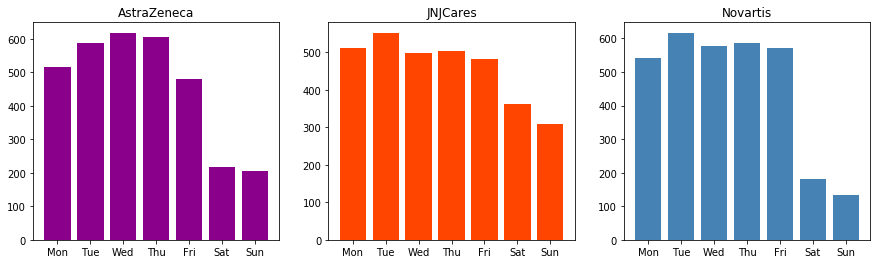

In [249]:
plt.figure(figsize = (15,4))
for company, i, c in zip(['AstraZeneca','JNJCares','Novartis'], range(1,4), ['darkmagenta','orangered','steelblue']): 
    
    date_dict = {'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
    
    for date in df_all['datetime'][df_all['company'] == company]:
        weekday = date.strftime('%A')
        date_dict[weekday] += 1

    plt.subplot(1, 3, i)  
    plt.bar(range(len(date_dict)), list(date_dict.values()), color = c)
    plt.xticks(range(len(date_dict)), list([x[:3] for x in date_dict.keys()]))
    plt.title(company)

plt.show()

J&J and Novartis  seem to keep the same level of activity during the rest of the weekday. J&J seems to tweet more frequently during the weekend than the other two.

In [250]:
df_day_of_w_like = df_all[['company', 'datetime','fav']].copy()
df_day_of_w_like['weekday'] = df_day_of_w_like['datetime'].apply(lambda x: x.strftime('%A'))

days_of_the_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

df_weekdays = df_day_of_w_like.groupby(['weekday', 'company'])[['fav']].median().unstack().astype(int)
df_weekdays.reindex(days_of_the_week)

fav                                                   \
company   AbbottGlobal Abbvie Amgen AstraZeneca BayerPharma Bmsnews GSK   
weekday                                                                   
Monday     1            8      5     10          6           9       1    
Tuesday    3            7      5     10          6           8       11   
Wednesday  2            8      5     9           6           8       10   
Thursday   5            8      5     9           6           7       13   
Friday     7            8      4     10          6           9       12   
Saturday   8            8      4     12          7           10      22   
Sunday     12           9      3     12          8           9       22   

                                                                               
company   GileadSciences JNJCares LillyPad Merck Novartis Pfizer Roche Sanofi  
weekday                                                                        
Monday     7              1        5        12    9        12     9     5      
Tuesday    6              2        4        15    11       12     10    6      
Wednesday  6              1        4        13    12       12     10    6      
Thursday   6              3        4        16    11       12     9     7      
Friday     7              2        4        17    13       11     9     6      
Saturday   6              2        5        17    18       12     12    7      
Sunday     7              3        4        24    17       14     12    6

Even though AZ posts **most frequently** on Wednesday, historically posts on that and the following day were the **least popular**. J&J and Novartis don't receive the most likes per post on their busies days as well. It seems that for a few companies tweeting during the weekend attracts more attention (e.g. Novartis, GSK or Abbott)



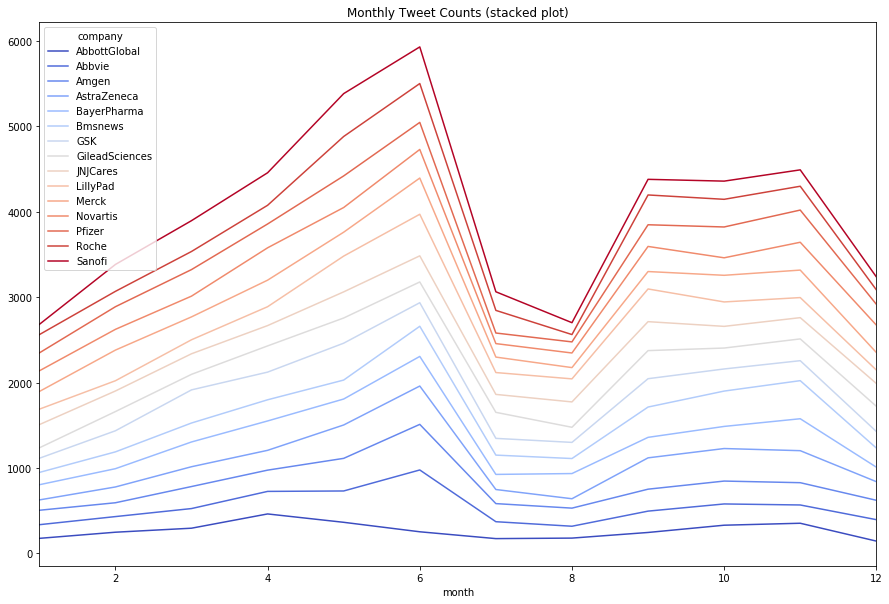

In [251]:
monthly_tweets = df_all.groupby(['month', 'company']).size().unstack()
monthly_tweets.plot(title = 'Monthly Tweet Counts (stacked plot)', stacked = True, colormap = 'coolwarm', figsize = (15,10))

Company Twitter accounts are the busiest just before the summer. During the holidays the activity significanlty drops

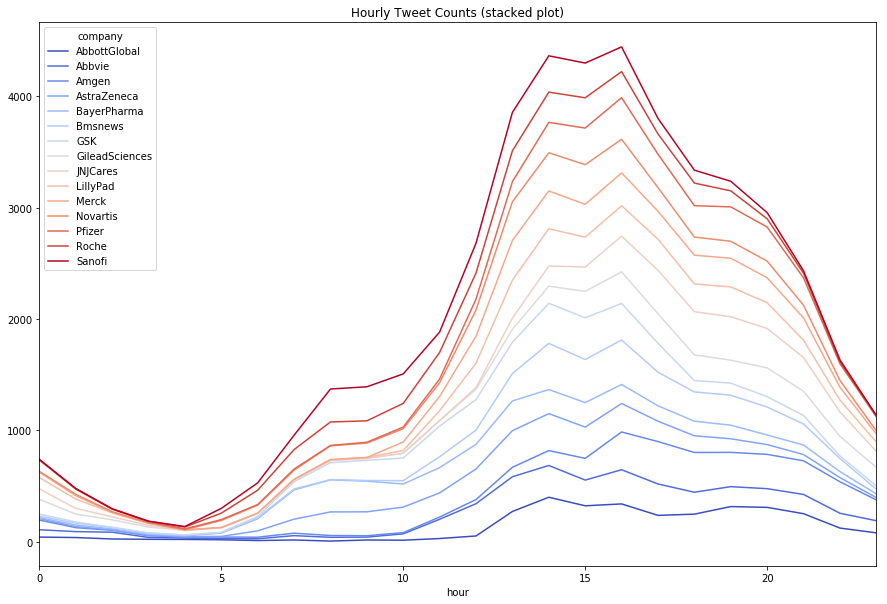

In [252]:
#Number of tweets posted at a particular hour

hourly_tweets = df_all.groupby(['hour', 'company']).size().unstack()
hourly_tweets.plot(title = 'Hourly Tweet Counts (stacked plot)', stacked = True, colormap = 'coolwarm', figsize = (15,10))

According to Twitter and this [answer](https://stackoverflow.com/questions/6935225/twitter-time-date-stamp-which-time-zone-is-it), each post's time is automatically converted to the local timezone.

Tweets that were posted in the afternoon or evening seem to be better received than the morning ones. Companies also tweet at those times more frequently.

Text(0, 0.5, 'Number of likes')

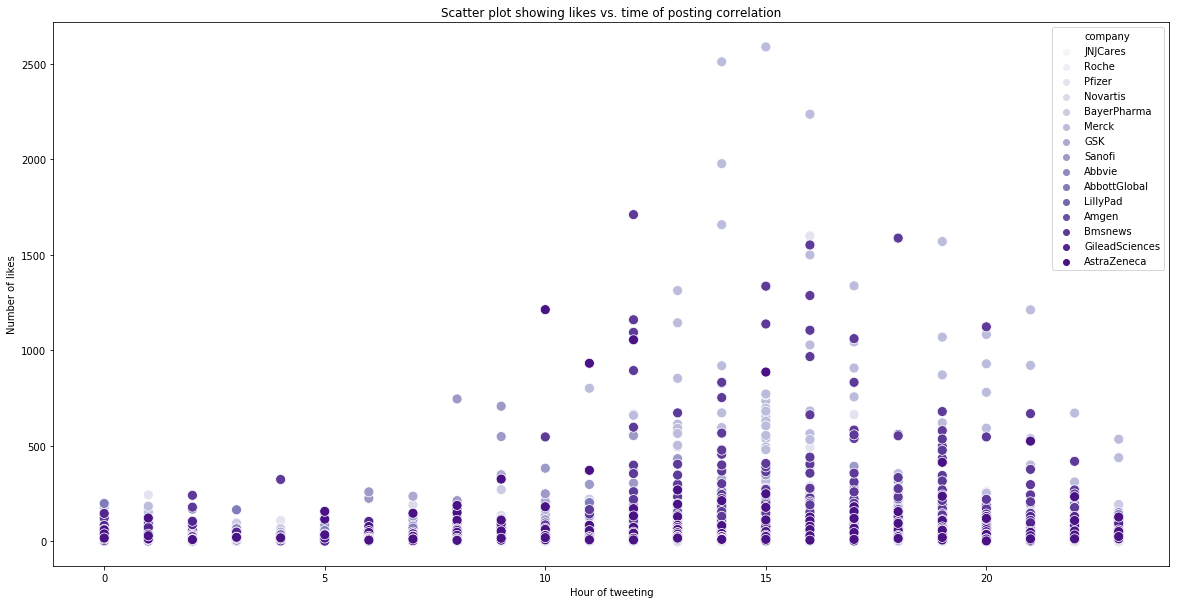

In [253]:
plt.figure(figsize = (20,10))
ax = sns.scatterplot(x = "hour", y = "fav", hue = "company", data = df_all, palette = "Purples", s = 100)
plt.title('Scatter plot showing likes vs. time of posting correlation')
plt.xlabel('Hour of tweeting')
plt.ylabel('Number of likes')

### Text normalisation

In order to faciliate further analysis it's essential to conduct text data pre-processing. I am going to:
- clean the text (remove special characters)
- convert text into lower-case words
- remove stopwords
- conduct lemmatization [(Wikipedia explanation)](https://en.wikipedia.org/wiki/Lemmatisation)

Hashtags and links (along with special characters) have already been removed in the previous step:
```python
    def clean_tweet(tweet):
        check = '(@[A-Za-z]+)|([^A-Za-z \t&])|(\w+:\/\/\S+)'
        return ' '.join(re.sub(check, ' ', tweet).split())
```
I kept **"&"** becuase "R&D" is a frequently used phrase and it's worth keeping it in the dataset

Stopwords are words that do not hold any useful information and can be easily removed from the dataset. They would only take space and unnecessarily increase processing time.

In [254]:
print(sorted(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

#### Lemmatization


```python
def lem_tweet(list_of_words):
    lemm = WordNetLemmatizer()
    return ' '.join([lemm.lemmatize(x.lower()) for x in list_of_words.split(' ') if x not in stop_words])
        
df_all['text_list_lemm'] = [lem_tweet(tweet) for tweet in df_all['clean_tweet']]
df_all['text_list_lemm'] = df_all['text_list_lemm'].str.split(' ')


```

That way (as seen below) the word **"families"** becomes **"family"**, **"consumers"** is now **"consumer"**. It's easier to get more accurate word count across the whole dataset.

In [255]:
df_all[['text', 'text_list_lemm']][10:11]

,text,text_list_lemm
10,"@modernspeedster @CheyanneTeresa Hi @modernspeedster! Thanks for sharing these lovely photos of your baby with us. We absolutely love looking at the beautiful baby pictures our consumers send to us, however, we hire outside agencies to handle our advertising and modeling. Hope this information helps!","[hi, thanks, sharing, lovely, photo, baby, u, absolutely, love, looking, beautiful, baby, picture, consumer, send, u, however, hire, outside, agency, handle, advertising, modeling, hope, information, help]"


### Most common words

- function <font color=blue>*get_all_words*</font> concatenates all tweets into a list of words (lemmatized or not, depending on the condition choosen)
- function <font color=blue>*popular_words_gen*</font> creates a table with most frequently used words for each company

In [256]:
def get_all_words(dataset, column_name):
    all_words = []

    for tweet in dataset[column_name]:
        for word in tweet:
            if word.lower() not in stop_words:
                all_words.append(word.lower())
    
    return all_words

In [257]:
def popular_words_gen(column_name, n):
    popular_words_pd = pd.DataFrame()

    for company in company_list_full:

        company_words = get_all_words(df_all[df_all['company'] == company], 'text_list_lemm')
        counter = collections.Counter(company_words)
        popular_words_pd[company] = [x[0] for x in counter.most_common(n)] 

    return popular_words_pd

popular_words_gen('text_list_lemm', 15)

,AbbottGlobal,Abbvie,Amgen,AstraZeneca,BayerPharma,Bmsnews,GSK,GileadSciences,JNJCares,LillyPad,Merck,Novartis,Pfizer,Roche,Sanofi
0,hi,learn,amgen,patient,patient,cancer,u,hiv,jnj,lilly,mrk,contact,learn,cancer,sanofi
1,u,u,learn,science,bayer,learn,contact,gilead,u,wearelilly,learn,novartis,patient,roche,vivatech
2,thanks,see,amgenonco,cancer,cancer,patient,help,learn,please,u,cancer,please,help,treatment,health
3,please,patient,patient,disease,u,research,gsk,u,learn,help,help,saw,cancer,learn,diabetes
4,team,cancer,migraine,new,stroke,u,find,people,thanks,medicine,latest,tweet,disease,patient,patient
5,note,help,u,research,dyk,c,please,today,team,patient,u,patient,health,new,people
6,send,new,cancer,help,learn,new,team,treatment,hear,thanks,thank,new,u,people,live
7,assist,read,new,treatment,help,dyk,thanks,new,like,learn,news,u,pfizer,u,global
8,help,research,today,learn,new,help,vaccine,hcv,help,new,patient,info,w,disease,new
9,lifetothefullest,abbviegivesback,disease,life,treatment,medium,crystal,community,product,life,health,follow,new,rog,u


### Most frequently used words in most popular tweets for each company

Let's see what words were most frequently used by each company in the first 100 of their most popular tweets

In [258]:
words_most_liked = []

def popular_words_gen(column_name, n):
    popular_words_pd = pd.DataFrame()

    for company in company_list_full:

        company_words = get_all_words(df_all[df_all['company'] == company].nlargest(100,['fav']), column_name)
        counter = collections.Counter(company_words)
        popular_words_pd[company] = [x[0] for x in counter.most_common(n)] 

    return popular_words_pd

popular_words_gen('text_as_list', 10)

,AbbottGlobal,Abbvie,Amgen,AstraZeneca,BayerPharma,Bmsnews,GSK,GileadSciences,JNJCares,LillyPad,Merck,Novartis,Pfizer,Roche,Sanofi
0,runners,learn,amgen,science,healthyaging,cancer,new,hiv,jnj,lilly,cancer,novartis,health,cancer,health
1,race,abbviegivesback,cancer,asco,learn,learn,today,gilead,help,wearelilly,learn,people,learn,immunotherapy,sanofi
2,today,us,patients,today,heart,research,behindthescience,worldaidsday,learn,better,inventingforlife,help,world,treatment,world
3,abbottwmm,day,disease,cancer,help,dyk,gsk,people,proud,today,people,working,support,roche,people
4,marathon,new,migraine,people,starts,patients,malaria,treatment,today,make,health,novartisnews,help,rog,women
5,boston,week,us,great,bayer,readyraiserise,vaccines,help,kids,new,frazier,new,people,rhhby,million
6,lounge,see,amgenonco,new,disease,us,scientists,today,world,people,ken,access,proud,first,global
7,lifetothefullest,cancer,learn,day,one,new,find,women,support,life,help,novartisaccess,today,positive,year
8,day,help,help,world,treatment,patient,world,living,hiv,learn,awareness,cancer,w,learn,science
9,run,employees,treatment,help,healthy,bms,vaccine,world,makehivhistory,work,aacr,accessinaction,cancer,lungcancer,zika


#### Most frequently occuring hashtags:

Usually it's the company own name that's the most frequently used hashtag. 

>**#DYK** - Do You Know  

In [259]:
popular_words_gen('hashtags', 5)

,AbbottGlobal,Abbvie,Amgen,AstraZeneca,BayerPharma,Bmsnews,GSK,GileadSciences,JNJCares,LillyPad,Merck,Novartis,Pfizer,Roche,Sanofi
0,abbottwmm,abbviegivesback,amgen,science,healthyaging,dyk,behindthescience,hiv,jnj,wearelilly,inventingforlife,novartisnews,afib,immunotherapy,diabetes
1,lifetothefullest,cancer,amgenonco,asco18,nutrition,readyraiserise,wellchildawards,worldaidsday,makehivhistory,diabetes,cancer,novartisaccess,prostatecancer,lungcancer,vaccineswork
2,tcsnycmarathon,puertorico,migraine,asco17,patient,cancer,vaccinateforlife,tedglobal,gcfest,lillyunited,humans4health,accessinaction,matterofmoments,personalisedhealthcare,zika
3,boston2019,rheumatology,aanam,pitchatpalace,ifato2018,imbreathingbecause,news,croi2018,changinghumanhealth,cancer,dearcancerheroes,endmalaria,vaccineswork,cancer,sanofi
4,wherechampionsrun,diversity,cancer,erscongress,bayer,asco17,throughthelabs,ias2017,givingtuesday,moreformbc,lungcancer,heartfailure,iwd2018,nsclc,zikavirus


#### Most frequently tagged accounts:

In [260]:
popular_words_gen('tagged', 10)

,AbbottGlobal,Abbvie,Amgen,AstraZeneca,BayerPharma,Bmsnews,GSK,GileadSciences,JNJCares,LillyPad,Merck,Novartis,Pfizer,Roche,Sanofi
0,abbottglobal,directrelief,amgen,asco,bayer,ericstonestreet,gsk,gileadsciences,jnjcares,lillypad,merck,novartis,pfizer,roche,sanofi
1,londonmarathon,cisnational,breakawaycancer,astrazeneca,helpwear_tech,dak,wellchild,aidsvu,savethechildren,unitedway,time,icrc,un,uicc,cidresearch
2,berlinmarathon,cityyear,amgenfoundation,myesmo,us_fda,bmsnews,medsformalaria,kitepharma,donateaphoto,us_fda,amdiabetesassn,avexisinc,theirc,wfhemophilia,accorhotelsnews
3,nycmarathon,uchiurbanlabs,statnews,medimmune,thezannatreza,tiamowry,23andme,untilorg,glblctzn,uwci,hiproviders,medsformalaria,hrc,cancereu,hpe_fr
4,wmmajors,stjude,salkhanacademy,thedukeofyork,janebarrattifa,texaschildrens,nature,janetjackson,gatesfoundation,lillydiabetes,fortunemagazine,ema_news,care,worldbladdercan,manpowergroupfr
5,ucsf,habitat_org,amgentoc,gregclarkmp,mattgallowaycbc,atlanticlive,comicrelief,sfgiants,girlup,nascar,potus,drtedros,worldvision,statnews,rcvaldeloire
6,bostonmarathon,fortunemagazine,breakawayhd,drtedros,metromorning,txccc,nytmag,cdcgov,jnjglobalhealth,driverryanreed,drewuniversity,vasnarasimhan,save_children,lungcancereu,sncf_digital
7,bigfootbiomed,phrma,us_fda,jesswade,wstrokecampaign,su2c,lindavillarosa,unaids,oneyoungworld,ethisphere,violadavis,emmanuelmacron,ilyasahshabazz,gehealthcare,sap
8,tokyo42195_org,ascopres,jayleno,erictopol,intfedageing,uicc,pfizer,forbes,unicef,iss_research,phillyinquirer,sandoz_global,berniceking,flatironhealth,sodexogroup
9,us_fda,galienfdn,time,robecosam,harvardbiz,robinroberts,pathtweets,aids_memorial,danaigurira,catalystinc,saaswim,cnbc,abbvie,ctadconference,groupetf1


#### Wordcloud of most common words of all companies

In [261]:
def wordcloud_gen(word_list):
    plt.figure(figsize = (30,30))
    wordcloud_ = WordCloud( background_color = 'white',
                            max_words = 600,
                            max_font_size = 200,
                            width = 1200, height = 800,
                            random_state = 42,
                            collocations = False
                            ).generate(' '.join([a for a in word_list]))
    plt.imshow(wordcloud_)
    plt.axis('off')
    plt.show()

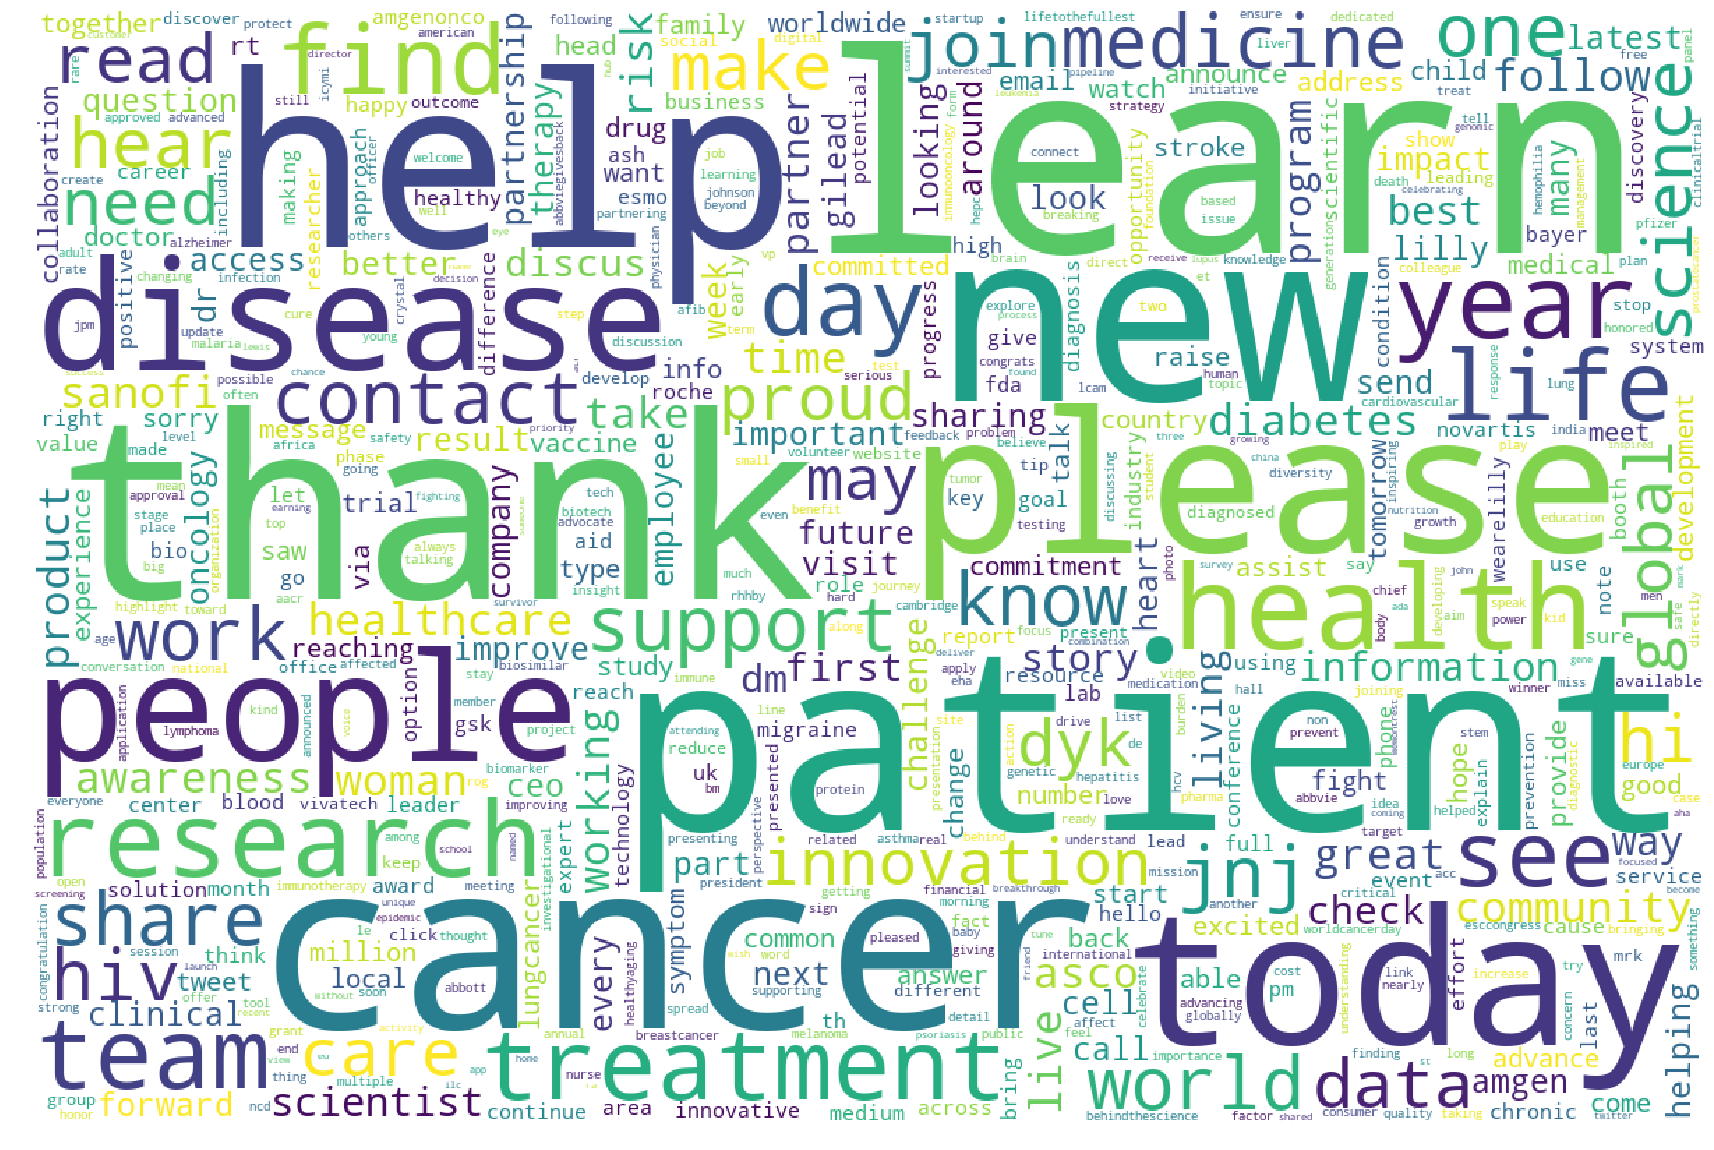

In [262]:
wordcloud_gen(get_all_words(df_all, 'text_list_lemm'))

#### Wordcloud of most common hashtags of all companies

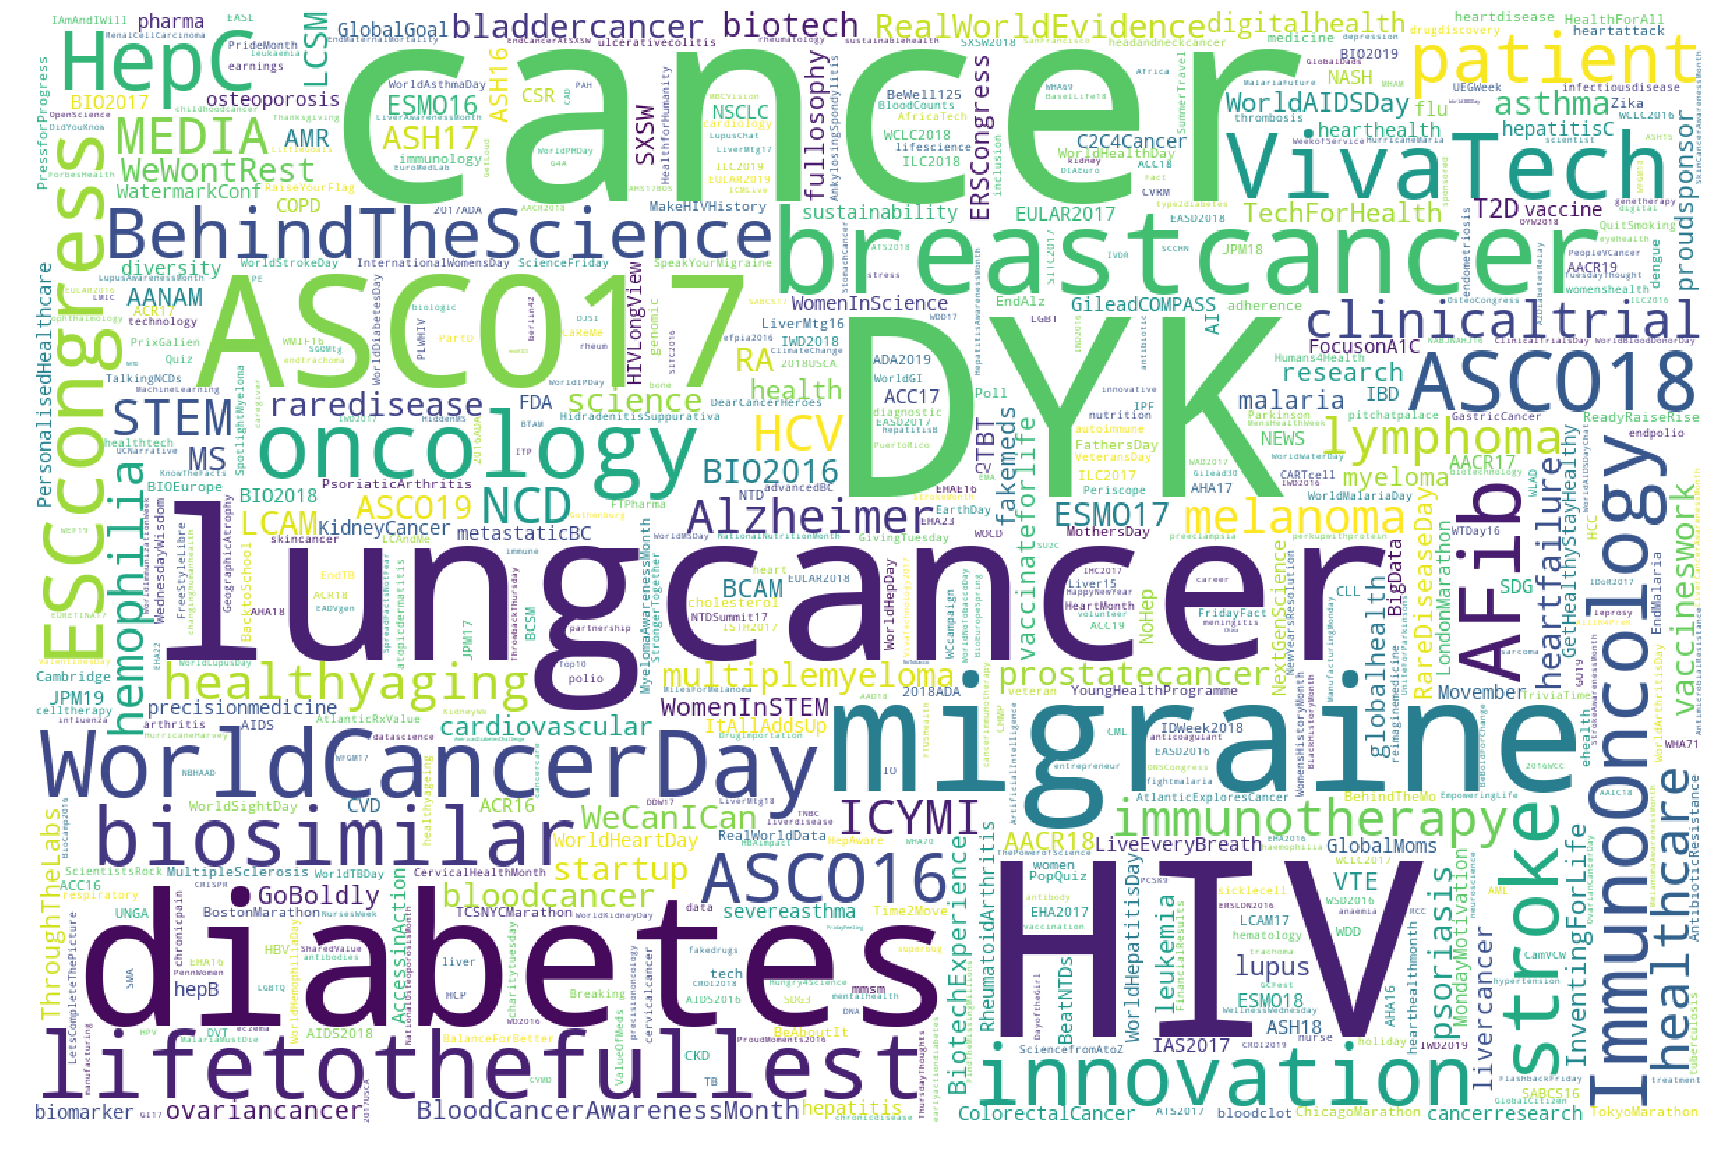

In [263]:
comp_hashtags = ['JNJ', 'Roche', 'Pfizer','Novartis', 'Bayer', 'Merck','GSK','Sanofi', 'abbvie', 'Abbott',
                'Lilly', 'Amgen', 'bms', 'GileadSciences', 'AstraZeneca', 'AZExchange']
list_h = []

for row in df_all['hashtags']:
    for hashtag in row:
        if not any(h.lower() in hashtag.lower() for h in comp_hashtags):
            list_h.append(hashtag)

wordcloud_gen(list_h)

  ### Which companies are using the most frequently occuring words
  
Function <font color=blue>*get_cfd_list*</font> creates a matrix with most popular words from all tweets and how frequently each of the companies uses those words.

In [264]:
def get_cfd_list(n, companies):
    cfd = ConditionalFreqDist()
    lemmatizer = WordNetLemmatizer() 
    
    counter = collections.Counter(get_all_words(df_all, 'text_list_lemm'))
    popular_words = [x[0] for x in counter.most_common(n)]
    
    for tweet, comp in zip(df_all['text_list_lemm'], df_all['company']):
        for word in tweet:
            if word.lower() in popular_words:
                cfd[comp][word] += 1
        
    return cfd.tabulate(conditions = companies, samples = popular_words)
    
cfd = get_cfd_list(11, company_list_full)
cfd

                     u   learn patient    help  cancer     new  please  thanks   today  people disease 
  AbbottGlobal     685     152      33     365       1     105     650     656     148      98      18 
        Abbvie     500     587     307     262     276     242      66     124     159     147     203 
         Amgen     283     582     416     189     217     216      83      44     212     126     206 
   AstraZeneca     179     209     647     258     436     313      32      52     179     194     346 
   BayerPharma     233     219     447     216     373     215      47     141     188     156     178 
       Bmsnews     294     603     436     224     789     236      40     100     138     116     122 
           GSK     505      63     182     404      64     278     343     306     163     149     150 
GileadSciences     334     490     170     170      97     227      13      23     241     299     147 
      JNJCares     909     534      61     427      46      98  

## "Measuring" empathy

#### AZ, Johnson & Johnson (J&J) and Novartis comparison

The table below shows the difference between AZ, J&J and Novartis. HBR's report from 2015 showed that AZ tweeter feed is not the most empathetic, contrary to Johnson & Johnson or Novartis (that report was from 2016).  

The first most obvious observation is that AZ uses significanlty less **thanks** or **please** in it's tweets. J&J also uses the most of the word __u__ (which is a lemmatized "you") and **help** out of all analysed companies. If we define empathy as "the ability to understand and share the feelings of another" using those words might imply the message being empathetic.

In [265]:
az_jnj_nov = ['AstraZeneca','JNJCares','Novartis']

cfd_ajn = get_cfd_list(11, az_jnj_nov)
cfd_ajn

                  u   learn patient    help  cancer     new  please  thanks   today  people disease 
AstraZeneca     179     209     647     258     436     313      32      52     179     194     346 
   JNJCares     909     534      61     427      46      98     574     531      66      87      56 
   Novartis     275     205     314     196     182     312     470     128     146     166     220 


#### Do Novartis and J&J do something differenlty basing on those two words?

Let's check who those three companies are tagging when using the word "thanks" or "please". Are they thanking individual people or companies?

In [266]:
def get_empathy_stats(company_list, references, empathetic_words):
    
    df_all['text_lower'] = [x.lower() for x in df_all['text']]
    
    df_polite = df_all[['company','tagged']][df_all['text_lower'].str.contains(empathetic_words)]
    df_polite = df_polite[df_polite.astype(str)['tagged'] != '[]']
    
    df_polite_out = pd.DataFrame()

    for company, reference in zip(company_list, references):
        tagged_list = []
        own_ref = 0
        tweets_with_tags = 0

        for row in df_polite['tagged'][df_polite['company'] == company]:
            for tagged in row:
                if tagged not in tagged_list:
                    tagged_list.append(tagged)
                if any(x.lower() in tagged.lower() for x in reference):
                    own_ref += 1
            tweets_with_tags += 1

        df_with_tags = df_all[['tagged']][(df_all["company"] == company)]
        df_with_tags = df_with_tags[df_with_tags.astype(str)['tagged'] != '[]']

        df_polite_out[company] = [len(tagged_list) , own_ref, tweets_with_tags, len(df_with_tags),
                                  str(round(own_ref/tweets_with_tags * 100, 2)) + '%']

    df_polite_out.rename(index={0 : 'Tagged accounts in "empathetic" tweets:',
                                1 : 'Times tagged ITSELF in an "empathetic" tweet:', 
                                2 : '"Empathetic" tweets with tags:', 
                                3 : 'Tweets containing ANY tag:',
                                4 : 'Percent of times account tagged ITSELF in an "empathetic tweet"'},
                                inplace = True)
    
    print("Empathetic words: {}".format(empathetic_words))
    
    return df_polite_out

In [267]:
references = [["AstraZeneca", "MedImmune"],["JNJ"], ["Novartis"]]
emathetic_words = "please|thanks|thank"

get_empathy_stats(az_jnj_nov, references, emathetic_words)

Empathetic words: please|thanks|thank


,AstraZeneca,JNJCares,Novartis
"Tagged accounts in ""empathetic"" tweets:",134,962,606
"Times tagged ITSELF in an ""empathetic"" tweet:",44,18,182
"""Empathetic"" tweets with tags:",99,1014,576
Tweets containing ANY tag:,1082,2098,1446
"Percent of times account tagged ITSELF in an ""empathetic tweet""",44.44%,1.78%,31.6%


Only every third of AZ's tweets contain a tag of another account, whereas J&J tags someone in 2/3 of their posts. Out of those three accounts AstraZeneca uses "thanks" or "please" the least. Moreover, in around a half of posts  with those two words AZ tagged itself (which J&J did less than 2%). J&J and Novartis tag other users' accounts more frequently than AZ in tweets containing "please" or "thanks".

The second list of words **please|thanks|thank|assist|...|recover)** was selected manually (by me) from words having the highest influence on post 'likeability'. I printed out 1000 first words from **show_most_informative_features** of NLTK package using the **NaiveBayesClassifier**. The model is presented below:

In [268]:
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
 
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from nltk import classify
from nltk import NaiveBayesClassifier

from random import shuffle

In [269]:
# I'm finding out which percentile that tweets is  regarding its popularity
df_all['percentile'] = df_all.groupby(['company'])['fav'].transform(lambda x: np.percentile(x,90))

# I am marking it as 'popular' if the number of likes was in the chosen top percentile for each company
df_all['popular_tf'] = df_all['percentile'] <= df_all['fav']

mapping = {True: 1, False: 0}
df_all['popular'] = df_all['popular_tf'].map(mapping)

df_analysis = df_all[['id','popular','text_as_list','text_list_lemm']]
 
hashtag_list = []
for hashtag in df_all['hashtags']:
        for h in hashtag:
            if h.lower() not in hashtag_list:
                hashtag_list.append(h.lower())

lemmatizer = WordNetLemmatizer()  

def bag_of_words(tweet):
    words_dictionary = dict([lemmatizer.lemmatize(word), True] for word in tweet if word not in hashtag_list)    
    return words_dictionary
 
pop_tweets = df_analysis['text_list_lemm'][df_analysis['popular']==1]
unpop_tweets = df_analysis['text_list_lemm'][df_analysis['popular']==0]

# popular tweets feature set
pop_tweets_set = []
for tweet in pop_tweets:
    pop_tweets_set.append((bag_of_words(tweet), 'pop')) 
    
# less popular tweets feature set
unpop_tweets_set = []
for tweet in unpop_tweets:
    unpop_tweets_set.append((bag_of_words(tweet), 'unpop'))

shuffle(pop_tweets_set)
shuffle(unpop_tweets_set)
 
test_set = pop_tweets_set[:1000] + unpop_tweets_set[:1000]
train_set = pop_tweets_set[1000:] + unpop_tweets_set[1000:]

classifier = NaiveBayesClassifier.train(train_set)

accuracy = classify.accuracy(classifier, test_set)
print('Model\'s accuracy: {} \n'.format(accuracy))
print(classifier.show_most_informative_features(10))

Model's accuracy: 0.5965 

Most Informative Features
                      dm = True            unpop : pop    =     53.9 : 1.0
                      hi = True            unpop : pop    =     49.2 : 1.0
                  assist = True            unpop : pop    =     42.0 : 1.0
                     com = True            unpop : pop    =     41.8 : 1.0
                     saw = True            unpop : pop    =     35.3 : 1.0
                 mileage = True              pop : unpop  =     32.0 : 1.0
                  lounge = True              pop : unpop  =     32.0 : 1.0
                    send = True            unpop : pop    =     31.7 : 1.0
                    note = True            unpop : pop    =     28.0 : 1.0
                 contact = True            unpop : pop    =     27.1 : 1.0
None


The classifier was trained on lemmatized tweets and is trying to show the most relevant features, regarding the Tweet classification as either 'popular' or 'unpopular'. You can read more about that package and selected methods [here](https://www.nltk.org/_modules/nltk/classify/naivebayes.html).

In [270]:
# emp = list of empathetic words
emp = "please|thanks|thank|assist|give|empathy|touch|reaffirm|kind|fragile|patience|facilitating|facilitate|recover"

references_all = [['Abbott'],['Abbvie'],['Amgen'],['AstraZeneca','MedImmune'],['Bayer'],['Bms'],['GSK'],
                  ['GileadSciences'],['JNJ'],['Lilly'],['Merck'],['Novartis'],['Pfizer'],['Roche'],['Sanofi']]

get_empathy_stats(company_list_full, references_all, emp)

Empathetic words: please|thanks|thank|assist|give|empathy|touch|reaffirm|kind|fragile|patience|facilitating|facilitate|recover


,AbbottGlobal,Abbvie,Amgen,AstraZeneca,BayerPharma,Bmsnews,GSK,GileadSciences,JNJCares,LillyPad,Merck,Novartis,Pfizer,Roche,Sanofi
"Tagged accounts in ""empathetic"" tweets:",907,270,205,153,240,130,652,120,1033,535,391,619,173,198,158
"Times tagged ITSELF in an ""empathetic"" tweet:",29,38,38,47,38,47,153,14,25,36,137,184,11,13,31
"""Empathetic"" tweets with tags:",1041,305,205,112,186,162,700,104,1108,521,400,591,162,201,124
Tweets containing ANY tag:,1799,1096,1270,1082,1021,923,1756,1141,2098,1568,993,1446,1130,524,1313
"Percent of times account tagged ITSELF in an ""empathetic tweet""",2.79%,12.46%,18.54%,41.96%,20.43%,29.01%,21.86%,13.46%,2.26%,6.91%,34.25%,31.13%,6.79%,6.47%,25.0%


**AstraZeneca**, **Merck** and **Novartis** are in the lead when it comes to tagging themselves in "empathetic" tweets. **Johnson&Johnson** tagged the highest number of unique other users' accounts and at the same time has the highest number of "empathetic" tweets. It also tags itself the least (only around 2% of their "empathetic" tweets referenced their account name). **Novartis** tags itself almost as frequently as AZ but tags more other accounts and posts "empathetic" tweets more frequently overall.

### Conclusion

The author of HBR's "Empathy ranking" didn't provide an exact recipe for measuring empathy. However, given that it involves caring about other people and interacting with them in a grateful and polite way it is possible to discover some rules for what might pass as empathy. 

There is no difference between AstraZeneca, Johnson & Johnson and Novartis when it comes to the tweeting frequency or timing but they differ in their choice of words. "Please" or "thank you" are not in AZ's top 10 most frequently used words but are common in tweets of the other two companies. Having chosen a short list of words that can be associated with empathy (that involve another person or the feeling of gratefulness) I checked how many tweets of the biggest pharmaceutical companies include them. Even though the list is not complete, it provides some insight into why some companies might be perceived as more empathetic

### References:
1. ["50 Companies That Get Twitter – and 50 That Don’t"](https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters)
2. [List of largest pharmaceutical companies by revenue](https://en.wikipedia.org/wiki/List_of_largest_pharmaceutical_companies_by_revenue)
3. [Twitter Dev Documentation](https://developer.twitter.com/en/docs)
4. ["It’s Time to Tweet—How Pharma Should Be Using Twitter"](https://www.pm360online.com/its-time-to-tweet-how-pharma-should-be-using-twitter/)

Notebook author's [github](https://github.com/mbalcerzak) account 